# Face Mask Classification


---

## Load dataset from kaggle

In [1]:
import os
os.environ['KAGGLE_USERNAME']= 'username'
os.environ['KAGGLE_KEY'] = 'key'

In [2]:
!kaggle datasets download -d omkargurav/face-mask-dataset

 99% 161M/163M [00:05<00:00, 39.1MB/s]
100% 163M/163M [00:05<00:00, 32.1MB/s]


In [3]:
import zipfile

local_zip = '/content/face-mask-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
path = '/content/data'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(path):
  for name in files:
    full_path.append(os.path.join(path, name))
    tag.append(path.split('/')[-1])
    file_name.append(name)

## Labeling dataset

In [5]:
import pandas as pd

df = pd.DataFrame({"path":full_path, "file_name": file_name, "tag":tag})
df.groupby(['tag']).size()

tag
with_mask       3725
without_mask    3828
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7553 entries, 0 to 7552
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       7553 non-null   object
 1   file_name  7553 non-null   object
 2   tag        7553 non-null   object
dtypes: object(3)
memory usage: 177.1+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Category')

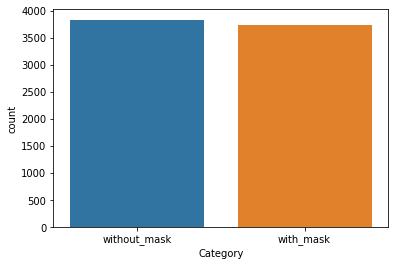

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df.tag)
plt.xlabel('Category')

In [8]:
df

,path,file_name,tag
0,/content/data/without_mask/without_mask_351.jpg,without_mask_351.jpg,without_mask
1,/content/data/without_mask/without_mask_2139.jpg,without_mask_2139.jpg,without_mask
2,/content/data/without_mask/without_mask_1387.jpg,without_mask_1387.jpg,without_mask
3,/content/data/without_mask/without_mask_1115.jpg,without_mask_1115.jpg,without_mask
4,/content/data/without_mask/without_mask_2520.jpg,without_mask_2520.jpg,without_mask
...,...,...,...
7548,/content/data/with_mask/with_mask_2982.jpg,with_mask_2982.jpg,with_mask
7549,/content/data/with_mask/with_mask_508.jpg,with_mask_508.jpg,with_mask
7550,/content/data/with_mask/with_mask_664.jpg,with_mask_664.jpg,with_mask
7551,/content/data/with_mask/with_mask_2241.jpg,with_mask_2241.jpg,with_mask


## Split dataset

In [9]:
from sklearn.model_selection import train_test_split

x = df['path']
y = df['tag']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size= 0.2, random_state=1
)

In [10]:
df_test = pd.DataFrame({
    'path' : x_test,
    'tag' : y_test,
    'set' : 'test-set'
})

df_train = pd.DataFrame({
    'path' : x_train,
    'tag' : y_train,
    'set' : 'train-set'
})

In [11]:
print('train size', len(df_train))
print('test size', len(df_test))

train size 6042
test size 1511


In [12]:
df_all = df_train.append([df_test]).reset_index(drop=1)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set        tag         
test-set   with_mask        744
           without_mask     767
train-set  with_mask       2981
           without_mask    3061
dtype: int64 




,path,tag,set
3533,/content/data/without_mask/without_mask_2416.jpg,without_mask,train-set
669,/content/data/with_mask/with_mask_3045.jpg,with_mask,train-set
7406,/content/data/with_mask/with_mask_1215.jpg,with_mask,test-set
3855,/content/data/with_mask/with_mask_2011.jpg,with_mask,train-set


## Move Dataset

In [13]:
import shutil
from tqdm.notebook import tqdm as tq

In [14]:
datasource_path = '/content/data'
dataset_path = '/content/dataset'

In [15]:
for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['tag'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(dataset_path, row['set'], row['tag'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['tag']))
  
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['tag'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

## Define Directory

In [16]:
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train-set')
test_dir = os.path.join(base_dir, 'test-set')

In [17]:
os.listdir(train_dir)

['without_mask', 'with_mask']

In [18]:
os.listdir(test_dir)

['without_mask', 'with_mask']

In [19]:
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
test_without_mask_dir = os.path.join(test_dir, 'without_mask')
test_with_mask_dir = os.path.join(test_dir, 'with_mask')

## Image Augmentation

In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.4.0


In [21]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'binary'
)

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


## Build CNN Model using Transfer Learning MobileNetV2

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

In [23]:
model = tf.keras.models.Sequential([
    MobileNetV2(weights = "imagenet", include_top= False, input_tensor = Input(shape=(224,224,3))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
___________________________________________________________

In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print('Akurasi mencapai 97%, proses training dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [25]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=1e-4)

model.compile(
    optimizer = opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs = 50,
    validation_data = test_generator,
    validation_steps = 3,
    callbacks = [callbacks]
)

Epoch 1/50
20/20 [==============================] - 17s 294ms/step - loss: 1.3926 - accuracy: 0.5679 - val_loss: 0.5105 - val_accuracy: 0.7708
Epoch 2/50
20/20 [==============================] - 5s 256ms/step - loss: 1.1786 - accuracy: 0.6486 - val_loss: 0.2360 - val_accuracy: 0.9375
Epoch 3/50
20/20 [==============================] - 5s 267ms/step - loss: 0.5289 - accuracy: 0.7953 - val_loss: 0.1309 - val_accuracy: 0.9167
Epoch 4/50
14/20 [====================>.........] - ETA: 1s - loss: 0.4051 - accuracy: 0.8488

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/20 [==============================] - 5s 261ms/step - loss: 0.3935 - accuracy: 0.8527 - val_loss: 0.9427 - val_accuracy: 0.8125
Epoch 5/50
20/20 [==============================] - 5s 266ms/step - loss: 0.4958 - accuracy: 0.8689 - val_loss: 0.3357 - val_accuracy: 0.8958
Epoch 6/50
20/20 [==============================] - 5s 257ms/step - loss: 0.2724 - accuracy: 0.8942 - val_loss: 0.3896 - val_accuracy: 0.8958
Epoch 7/50
20/20 [==============================] - 5s 236ms/step - loss: 0.1851 - accuracy: 0.9313 - val_loss: 0.5735 - val_accuracy: 0.8750
Epoch 8/50
20/20 [==============================] - 5s 239ms/step - loss: 0.1489 - accuracy: 0.9358 - val_loss: 0.5670 - val_accuracy: 0.8750
Epoch 9/50
20/20 [==============================] - 5s 255ms/step - loss: 0.3392 - accuracy: 0.8962 - val_loss: 0.3301 - val_accuracy: 0.9167
Epoch 10/50
20/20 [==============================] - 5s 245ms/step - loss: 0.2233 - accuracy: 0.9117 - val_loss: 0.3826 - val_accuracy: 0.9167
Epoch 11/50
20/2

## Plot Train and Test

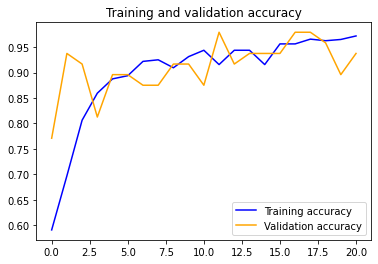

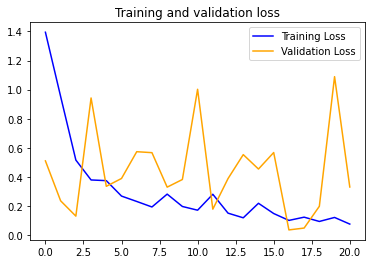

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predict

Saving IBVA5414.JPG to IBVA5414.JPG


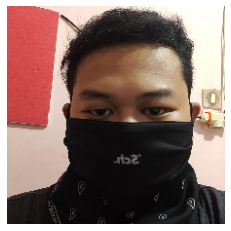

Not Wearing Masker


In [27]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path,target_size=(224,224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img = np.array(img, dtype='float')
  img = img.reshape(1, 224, 224, 3)
  prediksi = model.predict(img)
  idx = prediksi[0][0]
  if (idx):
      print("Not Wearing Masker")
  else:
      print("Wearing Masker")

## Evaluasi

Dikarenakan model tidak bisa memprediksi dengan benar, maka dibuat kembali model dengan custom CNN.

## CNN Build

In [31]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 256)       295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30976)            

In [32]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.85):
      print('Akurasi mencapai 85%, proses training dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [33]:
model_cnn.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs = 50,
    validation_data = test_generator,
    validation_steps = 3,
    callbacks = [callbacks]
)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.5238

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/20 [==============================] - 5s 221ms/step - loss: 0.7277 - accuracy: 0.5237 - val_loss: 0.6597 - val_accuracy: 0.5833
Epoch 2/50
20/20 [==============================] - 5s 230ms/step - loss: 0.6796 - accuracy: 0.6098 - val_loss: 0.6566 - val_accuracy: 0.6042
Epoch 3/50
20/20 [==============================] - 4s 213ms/step - loss: 0.6873 - accuracy: 0.5849 - val_loss: 0.6204 - val_accuracy: 0.6250
Epoch 4/50
20/20 [==============================] - 4s 212ms/step - loss: 0.6778 - accuracy: 0.5862 - val_loss: 0.5230 - val_accuracy: 0.7917
Epoch 5/50
20/20 [==============================] - 4s 216ms/step - loss: 0.5376 - accuracy: 0.7170 - val_loss: 0.3639 - val_accuracy: 0.8958
Epoch 6/50
20/20 [==============================] - 4s 212ms/step - loss: 0.5929 - accuracy: 0.7374 - val_loss: 0.3207 - val_accuracy: 0.8750
Epoch 7/50
20/20 [==============================] - 5s 237ms/step - loss: 0.4927 - accuracy: 0.7952 - val_loss: 0.4686 - val_accuracy: 0.8750
Epoch 8/50
20/20 

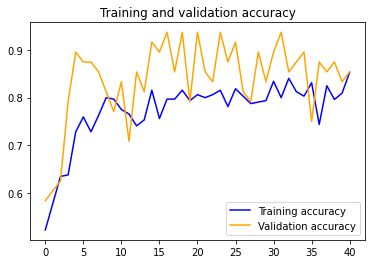

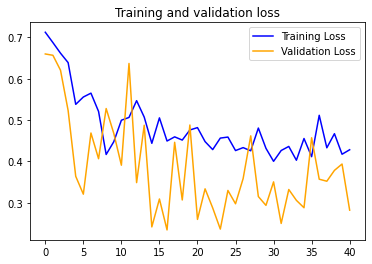

In [34]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving IMG_0836.JPG to IMG_0836.JPG


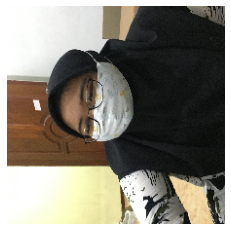

Wearing Masker


In [35]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path,target_size=(224,224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img = np.array(img, dtype='float')
  img = img.reshape(1, 224, 224, 3)
  prediksi = model_cnn.predict(img)
  idx = prediksi[0][0]
  if (idx):
      print("Not Wearing Masker")
  else:
      print("Wearing Masker")

Saving CZZR2628.JPG to CZZR2628 (1).JPG


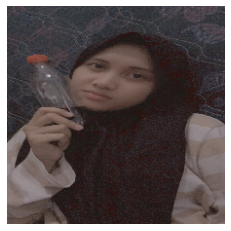

Not Wearing Masker


In [41]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path,target_size=(224,224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img = np.array(img, dtype='float')
  img = img.reshape(1, 224, 224, 3)
  prediksi = model_cnn.predict(img)
  idx = prediksi[0][0]
  if (idx):
      print("Not Wearing Masker")
  else:
      print("Wearing Masker")

## Save Model

In [42]:
model_cnn.save("/content/model_cnn.h5")